# Testing 2D Meshes using the meshr module

## To begin with, plotting a simple 2D circle

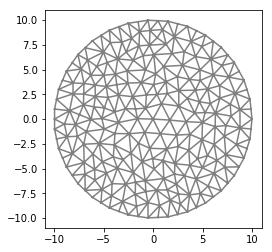

In [5]:
#importing the meshr module and the fenics module
from fenics import *
from mshr import *

#importing matplotlib to plot results 
from matplotlib import pyplot as plt

#importing timeit to time length of mesh creation
import time

#importing numpy to work with arrays
import numpy as np

#importing random to distribute masses on a mesh
import random

#need math to use sine and cosine
from math import sin,cos, pi

#defining the radius of a circle
big_radius = 10

#defining center of the circle
big_center = Point(0,0)

#Defining a Circle (case sensitive!), taking input the center and radius
big_circle = Circle(big_center, big_radius)

#declaring the domain using the built in command 
domain = big_circle

#generating the mesh for the defined domain and assigning the resolution (cells per direction x,y,z)
mesh = generate_mesh(domain, 10)

#Showing the mesh (UNCOMMENT TO SHOW)
plot(mesh)

## Looking at the time taken to generate meshes of different resolution

In [10]:
# WHEN ABOVE SCRIPT IS COMMENTED OUT, THIS ALSO IS OR IT WILL THROW ERRORS


# mesh_size = np.arange(10,150,10)
# mesh_time = []

# for i, size in enumerate(mesh_size):
#     #getting time at start of the loop
#     start_time = time.time()
#     #generating mesh of the given resolution
#     mesh = generate_mesh(domain, size)
#     #finding time taken since start of loop iteration
#     end_time = time.time()
#     #total time taken
#     time_taken = end_time - start_time
#     #appending to empty array
#     mesh_time = np.append(time_taken, mesh_time)  

# #as we append, the times are in reverse order, so we need to flip the array along 0 axis
# mesh_time = np.flip(mesh_time,0)

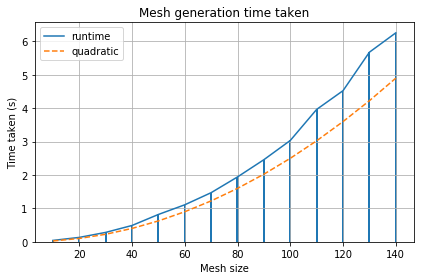

In [11]:


# plt.bar(mesh_size, mesh_time, )
# plt.plot(mesh_size, mesh_time, label = 'runtime')
# #plotting quadratic relation, scaled
# plt.plot(mesh_size, mesh_size**2/4000, linestyle = '--', label = 'quadratic')
# plt.title('Mesh generation time taken')
# plt.xlabel('Mesh size')
# plt.ylabel('Time taken (s)')
# plt.grid()
# plt.tight_layout()
# plt.legend()

## Next, we look at adding and subtracting geometries.
### Example 1: circle with hole

In [14]:
domain = big_circle

#doing the same as above, but with a different center and size of the circle
small_radius = 5
small_center = Point(0,0)
small_circle = Circle(small_center,small_radius)

#defining the domain as the big circle minus the small circle!
domain = big_circle - small_circle

mesh = generate_mesh(domain, 20)
#mesh

### Example 2: circle with subdomain
#### Empty cylinder

In [19]:
domain = big_circle

#inside radius of empty cylinder
in_radius = 2
#outside radius
out_radius = 2.2
in_center = Point(0,0)
#defining circles for in and outside, then subbin to get hollow cylinder
out_circle = Circle(in_center, out_radius)
in_circle = Circle(in_center,in_radius)

cylinder = out_circle - in_circle

#setting subdomain 
domain.set_subdomain(1, cylinder)

mesh = generate_mesh(domain, 10)

#mesh

#### Randomly scattered circles of uniform radius

In [23]:
rand_domain = Circle(big_center, big_radius)

#radius of subdomains
sub_radius = 0.5

#random centers from normal distribution for both x and y positions, *5 cause distribution is 0<x,y<1
sub_center_x = np.random.rand(1,10)*10 - 5
sub_center_y = np.random.rand(1,10)*10 - 5

#grouping x and y coordinates to feed to Circle
sub_coords = np.vstack((sub_center_x, sub_center_y))
sub_coords = np.transpose(sub_coords)

#Points of origin of each mass. each element of sub_coords is pair of coordinates. We make a point from each
#then make a circle around that origin with the chosen radius
sub_coords_points = [Circle(Point(coords),sub_radius) for coords in sub_coords]

#for each coordinate and circle defined above we make a subdomain. enumerate return the index i of the coords,
#so we use it to give the subdomain index. need to add 1 cause cannot use subdomain 0
for i, mass in enumerate(sub_coords_points):
    rand_domain.set_subdomain(i+100, mass)

mesh = generate_mesh(rand_domain, 20)
#mesh

#### Circles of uniform radius scattered around

In [27]:
circ_domain = Circle(big_center, big_radius)

#radius of subdomains
sub_radius = 4

#number of masses
sub_num = 10

#angles equally spaced apart
angles_N = [i*2*pi/sub_num for i in range(sub_num)]

# #centers are now around
sub_center_x = 5*[angle for angle in angles_N]
sub_center_y = 5*[angle for angle in angles_N]

# #grouping x and y coordinates to feed to Circle. have to transpose so each element sub_coords[i]
# #is a list of two coordinates
sub_coords = np.vstack((sub_center_x, sub_center_y))
sub_coords = np.transpose(sub_coords)

# #Points of origin of each mass. each element of sub_coords is pair of coordinates. We make a point from each
# #then make a circle around that origin with the chosen radius
sub_coords_points = [Circle(Point(coords),sub_radius) for coords in sub_coords]

# #for each coordinate and circle defined above we make a subdomain. enumerate return the index i of the coords,
# #so we use it to give the subdomain index. need to add 1 cause cannot use subdomain 0
for i, mass in enumerate(sub_coords_points):
    circ_domain.set_subdomain(i+1, mass)

mesh = generate_mesh(circ_domain, 20)
#mesh

# IMPORTANT: For some reason, using sin or cos kills the kernel, throws a lot of errors! So avoid whenever possible.
### For the above, points in a line were used instead (angles_N are not actually trated as angles)

## Other than that, mesh refinement using multiple subdomains seems like a good idea

### Testing with adding multiple subdomains to make mesh progressively finer around a point

In [31]:
ring_domain = Circle(big_center, big_radius)

#origin for each ring
ring_origin = Point(2,2)

#determining how many rings we create to refine mesh
how_fine = 40

#overall outer radius of concentric rings
ring_outer = big_radius/2

#radii of the subdomains we want to create, out to the radius of the domain big_radius,
#in how_fine steps. We subtract ring_outer/how_fine from the inner and add it to the outer 
#so the outer doesn't go out of bounds
radius_in = np.linspace(ring_outer/how_fine,ring_outer*(1-1/how_fine),how_fine)
radius_out = big_radius/how_fine + radius_in

#OPTIONAL: Scaling the radii so they increase quadratically
# radius_in = radius_in**2/radius_in.max()
# radius_out = radius_out**2/radius_out.max()

#defining a function to produce a ring from two circles
def make_ring(origin, radius_in, radius_out):
    circle_out = Circle(origin, radius_out)
    circle_in = Circle(origin, radius_in)
    ring = circle_out - circle_in
    return ring

#producing concentric rings from radius_in and radius_out
rings = [make_ring(ring_origin, radius_in[i], radius_out[i]) for i, ring in enumerate(radius_in)]

#assigning concentric rings to subdomains
[ring_domain.set_subdomain(i+1, ring) for i, ring in enumerate(rings)]

mesh = generate_mesh(ring_domain, 10)
mesh